In [ ]:
!nvidia-smi
!nvcc --version

Sat Jan 10 16:19:54 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# filter

cpu + gpu


In [ ]:
# @title
%%file /tmp/t2v1.cu

#include <stdio.h>
#include <cuda_runtime.h>
#include <stdlib.h>
#include <chrono>
#include <math.h>

#define _DEBUGY 1

#ifdef _DEBUGY
#define CHECK_ERR(err, a) { if (err != cudaSuccess) { \
    printf("%s(%d): %s\n", __FILE__, __LINE__, a); \
    } \
}
#else
#define CHECK_ERR(err, a) {}
#endif

// SoA: separate arrays for R, G, B
// Input: r_in[], g_in[], b_in[]
// Output: r_out[], g_out[], b_out[]

__global__ void blurKernelSoA(
    const float* __restrict__ r_in,//restrict  hint to the compiler that this pointer is the only way to access the data it points to during the scope of the function.
    const float* __restrict__ g_in,
    const float* __restrict__ b_in,
    float* __restrict__ r_out,
    float* __restrict__ g_out,
    float* __restrict__ b_out,
    int width, int height)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    auto clamp = [](int v, int lo, int hi) -> int {
        return (v < lo) ? lo : (v > hi ? hi : v);
    };

    float sum_r = 0.0f, sum_g = 0.0f, sum_b = 0.0f;
    int count = 0;

    for (int dy = -1; dy <= 1; dy++) {
        for (int dx = -1; dx <= 1; dx++) {
            int nx = clamp(x + dx, 0, width - 1);
            int ny = clamp(y + dy, 0, height - 1);
            int idx = ny * width + nx;

            sum_r += r_in[idx];
            sum_g += g_in[idx];
            sum_b += b_in[idx];
            count++;
        }
    }

    int out_idx = y * width + x;
    r_out[out_idx] = sum_r / count;
    g_out[out_idx] = sum_g / count;
    b_out[out_idx] = sum_b / count;
}

// CPU version (SoA)
void cpuBlurSoA(
    const float* r_in, const float* g_in, const float* b_in,
    float* r_out, float* g_out, float* b_out,
    int width, int height)
{
    auto clamp = [](int v, int lo, int hi) -> int {
        return (v < lo) ? lo : (v > hi ? hi : v);
    };

    for (int y = 0; y < height; y++) {
        for (int x = 0; x < width; x++) {
            float sum_r = 0.0f, sum_g = 0.0f, sum_b = 0.0f;
            int count = 0;

            for (int dy = -1; dy <= 1; dy++) {
                for (int dx = -1; dx <= 1; dx++) {
                    int nx = clamp(x + dx, 0, width - 1);
                    int ny = clamp(y + dy, 0, height - 1);
                    int idx = ny * width + nx;

                    sum_r += r_in[idx];
                    sum_g += g_in[idx];
                    sum_b += b_in[idx];
                    count++;
                }
            }

            int out_idx = y * width + x;
            r_out[out_idx] = sum_r / count;
            g_out[out_idx] = sum_g / count;
            b_out[out_idx] = sum_b / count;
        }
    }
}

//=============================================================================================

int main() {
    //const int WIDTH = 512;
    //const int HEIGHT = 512;
    //const int WIDTH = 10240;
    //const int HEIGHT = 10240;
    const int WIDTH = 1024;
    const int HEIGHT = 1024;
    const int NUM_PIXELS = WIDTH * HEIGHT;
    size_t size = NUM_PIXELS * sizeof(float);

    printf("SoA Blur: Image size %dx%d (%d pixels)\n", WIDTH, HEIGHT, NUM_PIXELS);

    // Timers
    cudaEvent_t t_start, t_stop;
    cudaEventCreate(&t_start);
    cudaEventCreate(&t_stop);

    // Host memory (pinned)
    float *h_r_in, *h_g_in, *h_b_in;
    float *h_r_out_gpu, *h_g_out_gpu, *h_b_out_gpu;
    cudaMallocHost(&h_r_in, size);
    cudaMallocHost(&h_g_in, size);
    cudaMallocHost(&h_b_in, size);
    cudaMallocHost(&h_r_out_gpu, size);
    cudaMallocHost(&h_g_out_gpu, size);
    cudaMallocHost(&h_b_out_gpu, size);

    float *h_r_out_cpu = (float*)malloc(size);
    float *h_g_out_cpu = (float*)malloc(size);
    float *h_b_out_cpu = (float*)malloc(size);

    if (!h_r_in || !h_g_in || !h_b_in ||
        !h_r_out_gpu || !h_g_out_gpu || !h_b_out_gpu ||
        !h_r_out_cpu || !h_g_out_cpu || !h_b_out_cpu) {
        printf("Host alloc failed!\n");
        return -1;
    }

    // Device memory
    float *d_r_in, *d_g_in, *d_b_in;
    float *d_r_out, *d_g_out, *d_b_out;
    cudaMalloc(&d_r_in, size);
    cudaMalloc(&d_g_in, size);
    cudaMalloc(&d_b_in, size);
    cudaMalloc(&d_r_out, size);
    cudaMalloc(&d_g_out, size);
    cudaMalloc(&d_b_out, size);
    CHECK_ERR(cudaGetLastError(), "cudaMalloc device");

    // Initialize input
    srand(42);
    for (int i = 0; i < NUM_PIXELS; i++) {
        h_r_in[i] = (float)rand() / RAND_MAX * 255.0f;
        h_g_in[i] = (float)rand() / RAND_MAX * 255.0f;
        h_b_in[i] = (float)rand() / RAND_MAX * 255.0f;
    }

    // --- CPU blur ---
    auto tcpu_start = std::chrono::high_resolution_clock::now();
    cpuBlurSoA(h_r_in, h_g_in, h_b_in,
               h_r_out_cpu, h_g_out_cpu, h_b_out_cpu,
               WIDTH, HEIGHT);
    auto tcpu_stop = std::chrono::high_resolution_clock::now();
    float cpu_ms = std::chrono::duration_cast<std::chrono::microseconds>(tcpu_stop - tcpu_start).count() / 1000.0f;
    printf("CPU time: %.3f ms\n", cpu_ms);

    // --- GPU blur ---
    cudaMemcpy(d_r_in, h_r_in, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_g_in, h_g_in, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b_in, h_b_in, size, cudaMemcpyHostToDevice);
    CHECK_ERR(cudaGetLastError(), "H2D input");

    dim3 blockSize(16, 16);
    dim3 gridSize((WIDTH + blockSize.x - 1) / blockSize.x,
                  (HEIGHT + blockSize.y - 1) / blockSize.y);

    cudaEventRecord(t_start);
    blurKernelSoA<<<gridSize, blockSize>>>(
        d_r_in, d_g_in, d_b_in,
        d_r_out, d_g_out, d_b_out,
        WIDTH, HEIGHT);
    CHECK_ERR(cudaGetLastError(), "blurKernelSoA launch");

    cudaMemcpy(h_r_out_gpu, d_r_out, size, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_g_out_gpu, d_g_out, size, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_b_out_gpu, d_b_out, size, cudaMemcpyDeviceToHost);
    CHECK_ERR(cudaGetLastError(), "D2H output");

    cudaEventRecord(t_stop);
    cudaEventSynchronize(t_stop);
    float gpu_ms = 0;
    cudaEventElapsedTime(&gpu_ms, t_start, t_stop);
    printf("GPU time: %.3f ms\n", gpu_ms);

    // --- Validation ---
    const float tolerance = 1e-4f;
    int errors = 0;
    float max_err = 0.0f;
    const int sample_count = 1000;

    for (int i = 0; i < sample_count; i++) {
        int idx = rand() % NUM_PIXELS;
        float dr = fabsf(h_r_out_gpu[idx] - h_r_out_cpu[idx]);
        float dg = fabsf(h_g_out_gpu[idx] - h_g_out_cpu[idx]);
        float db = fabsf(h_b_out_gpu[idx] - h_b_out_cpu[idx]);
        float err = fmaxf(fmaxf(dr, dg), db);

        if (err > tolerance) {
            errors++;
            if (errors <= 3) {
                printf("Mismatch at %d: GPU(%.3f,%.3f,%.3f) CPU(%.3f,%.3f,%.3f) diff=%.6f\n",
                       idx,
                       h_r_out_gpu[idx], h_g_out_gpu[idx], h_b_out_gpu[idx],
                       h_r_out_cpu[idx], h_g_out_cpu[idx], h_b_out_cpu[idx],
                       err);
            }
        }
        if (err > max_err) max_err = err;
    }

    printf("\nSoA Validation: %d errors in %d samples, max error = %.6f\n",
           errors, sample_count, max_err);

    // Cleanup
    cudaFreeHost(h_r_in); cudaFreeHost(h_g_in); cudaFreeHost(h_b_in);
    cudaFreeHost(h_r_out_gpu); cudaFreeHost(h_g_out_gpu); cudaFreeHost(h_b_out_gpu);
    free(h_r_out_cpu); free(h_g_out_cpu); free(h_b_out_cpu);
    cudaFree(d_r_in); cudaFree(d_g_in); cudaFree(d_b_in);
    cudaFree(d_r_out); cudaFree(d_g_out); cudaFree(d_b_out);
    cudaEventDestroy(t_start);
    cudaEventDestroy(t_stop);

    return 0;
}

Writing /tmp/t2v1.cu


In [ ]:
# @title
!nvcc -arch=sm_75 /tmp/t2v1.cu -o /tmp/t2v1
# @title
# run the executable with nvprof
!nvprof /tmp/t2v1


SoA Blur: Image size 1024x1024 (1048576 pixels)
==1547== NVPROF is profiling process 1547, command: /tmp/t2v1
CPU time: 161.856 ms
GPU time: 1.386 ms

SoA Validation: 0 errors in 1000 samples, max error = 0.000000
==1547== Profiling application: /tmp/t2v1
==1547== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   46.82%  1.0302ms         3  343.41us  341.59us  344.86us  [CUDA memcpy HtoD]
                   43.64%  960.11us         3  320.04us  319.51us  320.31us  [CUDA memcpy DtoH]
                    9.54%  209.95us         1  209.95us  209.95us  209.95us  blurKernelSoA(float const *, float const *, float const *, float*, float*, float*, int, int)
      API calls:   90.62%  208.02ms         2  104.01ms     719ns  208.02ms  cudaEventCreate
                    5.21%  11.950ms         6  1.9916ms  1.7297ms  3.0563ms  cudaHostAlloc
                    1.47%  3.3731ms         6  562.18us  502.98us  734.74us  cudaFreeHost

### fILTER NEW

In [ ]:
# @title
%%file /tmp/newblur.cu

#include <stdio.h>
#include <cuda_runtime.h>
#include <stdlib.h>
#include <chrono>
#include <math.h>

#define DODEBUG 1

#ifdef DODEBUG
#define CHECK_ERR(err, a) {if (err!= cudaSuccess) { \
 printf("err here %s %d %s ", __FILE__,__LINE__,a ); \
 ; \
}}
#else
#define CHECK_ERR(err, a) {}
#endif

//onethread
__global__ void kernelblur(const float* r_inarr,const float* g_inarr,const float* b_inarr, float* r_ouarr, float* g_ouarr, float* b_ouarr,const int width,const int height){
  int x = blockDim.x*blockIdx.x + threadIdx.x;
  int y = blockDim.y*blockIdx.y + threadIdx.y;

  if (x >=width || y>=height) return;

  auto clump = [](int cur, int low, int hig)-> int{ //newid
      return (cur<low) ? low : ((cur>hig) ? hig : cur);
  };
  //int nx = (x + dx < 0) ? 0 : ((x + dx >= width) ? width - 1 : x  +  dx);
  //int ny = (y + dy < 0) ? 0 : ((y + dy >= height) ? height - 1 : y + dy);

  float sum_r = 0.0f;
  float sum_g = 0.0f;
  float sum_b = 0.0f;
  int count =0;//9 always

  for (int dy = -1; dy<=1; dy++){//3x3 offset gen
  for (int dx = -1; dx<=1; dx++){
      int tempidx = clump(x+dx,0,width -1);
      int tempidy = clump(y+dy,0,height-1);
      int tempind = tempidy*width + tempidx;

      sum_r += r_inarr[tempind];
      sum_g += g_inarr[tempind];
      sum_b += b_inarr[tempind];
      count++;
  }
  }

  int outind = y*width + x;
  r_ouarr[outind] = sum_r/count;
  g_ouarr[outind] = sum_g/count;
  b_ouarr[outind] = sum_b/count;
}

//all at the same time
void cpublur(const float* r_inarr,const float* g_inarr,const float* b_inarr, float* r_ouarr, float* g_ouarr, float* b_ouarr,const int width,const int height){


  auto clump = [](int cur, int low, int hig)-> int{ //newid
      return (cur<low) ? low : ((cur>hig) ? hig : cur);
  };
  //int nx = (x + dx < 0) ? 0 : ((x + dx >= width) ? width - 1 : x   + dx);
  //int ny = (y + dy < 0) ? 0 : ((y + dy >= height) ? height - 1 : y + dy);

  //if (x >=width || y>=height) return;
  for (int x = 0; x<width;  x++){//whichpixelredo
  for (int y = 0; y<height; y++){
  float sum_r = 0.0f;
  float sum_g = 0.0f;
  float sum_b = 0.0f;
  int count =0;//9 always

  for (int dy = -1; dy<=1; dy++){//3x3 offset gen
    for (int dx = -1; dx<=1; dx++){
      int tempidx = clump(x+dx,0,width  -1);
      int tempidy = clump(y+dy,0,height -1);
      int tempind = tempidy*width + tempidx;
      sum_r += r_inarr[tempind];
      sum_g += g_inarr[tempind];
      sum_b += b_inarr[tempind];
      count++;
      }
    }//onepixeldonesum

  int outind = y*width + x;
  r_ouarr[outind] = sum_r/count;
  g_ouarr[outind] = sum_g/count;
  b_ouarr[outind] = sum_b/count;
  }
  }//allpixelsdone
}//cpukernend

//=============================================================================================

int main() {
    const int WIDTH    = 1024;
    const int HEIGH    = 1024;
    const int N_PXL    = WIDTH * HEIGH;
    const size_t SIZEA = N_PXL * sizeof(float);

    float *h_r_in, *h_g_in, *h_b_in;//hostin
    float *h_r_ou, *h_g_ou, *h_b_ou;//hostout
    float *g_r_ou, *g_g_ou, *g_b_ou;//hostoutofgpu

    cudaMallocHost(&h_r_in, SIZEA);
    cudaMallocHost(&h_g_in, SIZEA);
    cudaMallocHost(&h_b_in, SIZEA);
    cudaMallocHost(&g_r_ou, SIZEA);
    cudaMallocHost(&g_g_ou, SIZEA);
    cudaMallocHost(&g_b_ou, SIZEA);
    h_r_ou = (float*)malloc(SIZEA);
    h_g_ou = (float*)malloc(SIZEA);
    h_b_ou = (float*)malloc(SIZEA);

    if(!h_r_in||!h_g_in||!h_b_in||
       !h_r_ou||!h_g_ou||!h_b_ou||
       !g_r_ou||!g_g_ou||!g_b_ou){
       printf("Hostallocdead");
       return -1;
       }

    float *d_r_in, *d_g_in, *d_b_in;//devicein
    float *d_r_ou, *d_g_ou, *d_b_ou;//deviceout
    cudaMalloc(&d_r_in, SIZEA);
    cudaMalloc(&d_g_in, SIZEA);
    cudaMalloc(&d_b_in, SIZEA);
    cudaMalloc(&d_r_ou, SIZEA);
    cudaMalloc(&d_g_ou, SIZEA);
    cudaMalloc(&d_b_ou, SIZEA);
    CHECK_ERR(cudaGetLastError(), "cudaMalloc device");

    srand(456789);
    for (int i = 0; i<N_PXL; i++){
        h_r_in[i] = (float)rand() / RAND_MAX * 255.0f;
        h_g_in[i] = (float)rand() / RAND_MAX * 255.0f;
        h_b_in[i] = (float)rand() / RAND_MAX * 255.0f;
    }

    auto htstar = std::chrono::high_resolution_clock::now();
    cpublur(h_r_in,h_g_in,h_b_in,h_r_ou,h_g_ou,h_b_ou,WIDTH,HEIGH);
    auto htstop = std::chrono::high_resolution_clock::now();
    float cpu_ms = std::chrono::duration_cast<std::chrono::microseconds>(htstop - htstar).count() / 1000.0f;
    printf("CPU time: %.3f ms\n", cpu_ms);

    cudaEvent_t tstar;
    cudaEvent_t tstop;
    cudaEventCreate(&tstar);
    cudaEventCreate(&tstop);

    cudaMemcpy(d_r_in, h_r_in, SIZEA, cudaMemcpyHostToDevice);
    cudaMemcpy(d_g_in, h_g_in, SIZEA, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b_in, h_b_in, SIZEA, cudaMemcpyHostToDevice);
    CHECK_ERR(cudaGetLastError(), "h2d");

    dim3 blockSize(16, 16);
    dim3 gridSize((WIDTH + blockSize.x - 1)/blockSize.x,
                  (HEIGH + blockSize.y - 1)/blockSize.y);

         cudaEventRecord(tstar);
    kernelblur<<<gridSize,blockSize>>>(d_r_in,d_g_in,d_b_in,d_r_ou,d_g_ou,d_b_ou,WIDTH,HEIGH);
    CHECK_ERR(cudaGetLastError(), "kernelblur");
    cudaMemcpy(g_r_ou, d_r_ou, SIZEA, cudaMemcpyDeviceToHost);
    cudaMemcpy(g_g_ou, d_g_ou, SIZEA, cudaMemcpyDeviceToHost);
    cudaMemcpy(g_b_ou, d_b_ou, SIZEA, cudaMemcpyDeviceToHost);
    CHECK_ERR(cudaGetLastError(), "d2h");
         cudaEventRecord(tstop);
    cudaEventSynchronize(tstop);
    float gtime = -1;
    cudaEventElapsedTime(&gtime, tstar, tstop);
    printf("GPU time: %.3f ms\n", gtime);

    // --- Validation ---
    const float TOL = 1e-3f; // tolerance for floating-point comparison
    bool valid = true;
    int mismatch_count = 0;
    const int max_report = 5; // report first few mismatches

    for (int i = 0; i < N_PXL; ++i) {
    float dr = fabsf(h_r_ou[i] - g_r_ou[i]);
    float dg = fabsf(h_g_ou[i] - g_g_ou[i]);
    float db = fabsf(h_b_ou[i] - g_b_ou[i]);
    if (dr > TOL || dg > TOL || db > TOL) {
    if (mismatch_count < max_report) {
    printf("Mismatch at pixel %d: CPU(%.3f,%.3f,%.3f) vs GPU(%.3f,%.3f,%.3f)\n",
    i, h_r_ou[i], h_g_ou[i], h_b_ou[i],
    g_r_ou[i], g_g_ou[i], g_b_ou[i]);    }
    mismatch_count++;
    valid = false;
    }
    }
    if (valid) { printf(" Validation PASSED: %.1e\n", TOL);}
    else { printf("Validation FAILED: %d / %d pixels differ beyond tolerance %.1e\n", mismatch_count, N_PXL, TOL);}

    cudaFreeHost(h_r_in); cudaFreeHost(h_g_in); cudaFreeHost(h_b_in);
    cudaFreeHost(g_r_ou); cudaFreeHost(g_g_ou); cudaFreeHost(g_b_ou);
    free(h_r_ou); free(h_g_ou); free(h_b_ou);

    cudaFree(d_r_in); cudaFree(d_g_in); cudaFree(d_b_in);
    cudaFree(d_r_ou); cudaFree(d_g_ou); cudaFree(d_b_ou);
    cudaEventDestroy(tstar);
    cudaEventDestroy(tstop);

    return 0;
}

Overwriting /tmp/newblur.cu


In [ ]:
# @title
!nvcc -arch=sm_75  /tmp/newblur.cu -o  /tmp/newblur
# @title
# run the executable with nvprof
!nvprof /tmp/newblur


==2599== NVPROF is profiling process 2599, command: /tmp/newblur
CPU time: 295.686 ms
GPU time: 1.479 ms
 Validation PASSED: 1.0e-03
==2599== Profiling application: /tmp/newblur
==2599== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   47.35%  1.0881ms         3  362.69us  343.99us  399.22us  [CUDA memcpy HtoD]
                   43.51%  999.88us         3  333.29us  320.28us  357.50us  [CUDA memcpy DtoH]
                    9.14%  209.95us         1  209.95us  209.95us  209.95us  kernelblur(float const *, float const *, float const *, float*, float*, float*, int, int)
      API calls:   95.68%  219.74ms         6  36.623ms  2.3946ms  207.48ms  cudaHostAlloc
                    2.25%  5.1756ms         6  862.60us  791.85us  1.0570ms  cudaFreeHost
                    1.05%  2.4192ms         6  403.20us  334.43us  577.25us  cudaMemcpy
                    0.53%  1.2261ms         6  204.35us  134.86us  240.26us  cudaFree

# Urmat teplo


cpu

In [ ]:
# @title
%%file /tmp/t1v1.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>
#include <algorithm>
#include <chrono>

// Параметры задачи
#define NX 256           // Количество узлов по x
#define NY 256           // Количество узлов по y
#define DX (1.0/(NX-1)) // Шаг по пространству
#define DY (1.0/(NY-1))
#define C 1.0           // Коэффициент теплопроводности

// Автоматический расчет устойчивого шага по времени
#define DT (0.25 * fmin(DX*DX, DY*DY) / C) // Условие Куранта

double** allocate_2d_array(int rows, int cols) {
    double** arr = (double**)malloc(rows * sizeof(double*));
    for (int i = 0; i < rows; i++) {
        arr[i] = (double*)calloc(cols, sizeof(double)); // Используем calloc для инициализации нулями
    }
    return arr;
}

void free_2d_array(double** arr, int rows) {
    for (int i = 0; i < rows; i++) {
        free(arr[i]);
    }
    free(arr);
}

// Инициализация начальных и граничных условий
void initialize(double** u) {
    // Начальное условие: u(x,y,0) = 1.0
    for (int i = 0; i < NX; i++) {
        for (int j = 0; j < NY; j++) {
            u[i][j] = 1.0;
        }
    }

    // Граничные условия: u = 2.0 на всех границах
    for (int i = 0; i < NX; i++) {
        u[i][0] = 2.0;
        u[i][NY-1] = 2.0;
    }

    for (int j = 0; j < NY; j++) {
        u[0][j] = 2.0;
        u[NX-1][j] = 2.0;
    }
}

// Один шаг по времени методом крест
void time_step(double** u, double** u_new) {
    double dx2 = DX * DX;
    double dy2 = DY * DY;

    // Копируем граничные условия
    for (int i = 0; i < NX; i++) {
        u_new[i][0] = u[i][0];
        u_new[i][NY-1] = u[i][NY-1];
    }
    for (int j = 0; j < NY; j++) {
        u_new[0][j] = u[0][j];
        u_new[NX-1][j] = u[NX-1][j];
    }

    // Вычисление новых значений во внутренних точках
    for (int i = 1; i < NX - 1; i++) {
        for (int j = 1; j < NY - 1; j++) {
            double laplacian = (u[i-1][j] - 2*u[i][j] + u[i+1][j]) / dx2 +
                              (u[i][j-1] - 2*u[i][j] + u[i][j+1]) / dy2;

            u_new[i][j] = u[i][j] + DT * C * laplacian;

            // Проверка на численную устойчивость
            if (!std::isfinite(u_new[i][j])) {
                printf("Numerical instability at (%d, %d)! Value = %f\n", i, j, u_new[i][j]);
                return;
            }
        }
    }
}

// Вычисление максимального изменения за шаг (для мониторинга)
double max_change(double** u, double** u_new) {
    double max_diff = 0.0;
    for (int i = 1; i < NX - 1; i++) {
        for (int j = 1; j < NY - 1; j++) {
            double diff = fabs(u_new[i][j] - u[i][j]);
            if (diff > max_diff) {
                max_diff = diff;
            }
        }
    }
    return max_diff;
}

void save_to_file(double** u, const char* filename, double t) {
    FILE* file = fopen(filename, "w");
    if (!file) {
        printf("Error opening file %s\n", filename);
        return;
    }

    fprintf(file, "# Time: %.6f\n", t);
    fprintf(file, "# X Y U\n");

    for (int i = 0; i < NX; i++) {
        for (int j = 0; j < NY; j++) {
            fprintf(file, "%.6f %.6f %.6f\n", i*DX, j*DY, u[i][j]);
        }
    }

    fclose(file);
    printf("Saved to %s\n", filename);
}

int main(int argc, char* argv[]) {
    double target_time = 0.1;
    if (target_time <= 0) {
        printf("Error: target_time must be positive\n");
        return 1;
    }

    printf("Solving heat equation until t = %.6f\n", target_time);
    printf("Grid: %dx%d, dx=%.6f, dy=%.6f\n", NX, NY, DX, DY);
    printf("Automatic time step: dt=%.8f (for stability)\n", DT);
    printf("Courant number: %.6f\n", C * DT * (1.0/(DX*DX) + 1.0/(DY*DY)));

    double** u_current = allocate_2d_array(NX, NY);
    double** u_next = allocate_2d_array(NX, NY);
    initialize(u_current);
    initialize(u_next);

    double t = 0.0;
    int step = 0;
    printf("Step 0: t = %.6f\n", t);
    auto start_computation = std::chrono::high_resolution_clock::now();

    // Основной цикл по времени
    while (t < target_time) {
        // Если осталось меньше чем DT, уменьшаем шаг
        double actual_dt = DT;
        if (t + DT > target_time) {
            actual_dt = target_time - t;
        }

        time_step(u_current, u_next);
        std::swap(u_current, u_next);

        t += actual_dt;
        step++;

        // Вывод прогресса каждые 1000 шагов
        if (step % 1000 == 0) {
            double max_diff = max_change(u_next, u_current);
            printf("Step %d: t = %.6f, max change = %.8f\n", step, t, max_diff);
        }

        // Аварийный выход при неустойчивости
        if (step > 1000000) { // Защита от бесконечного цикла
            printf("Too many steps, possible instability!\n");
            break;
        }
    }

    auto end_computation = std::chrono::high_resolution_clock::now();

    printf("Final: step %d, t = %.6f\n", step, t);

    save_to_file(u_current, "solution_final.txt", t);

    // СИММЕТРИЧНЫЙ вывод среза для проверки (ИСПРАВЛЕННЫЙ)
    printf("\nSymmetric slice at y = %d (middle):\n", NY/2);
    printf("Left part (from center to left boundary):\n");

    // Используем безопасные границы
    int center = NX / 2;
    int max_offset = center; // максимальный offset до левой границы

    for (int offset = 0; offset <= max_offset; offset += NX/16) {
        int left_x = center - offset;
        int right_x = center + offset;

        // Проверяем границы для безопасности
        if (left_x >= 0 && left_x < NX && right_x >= 0 && right_x < NX) {
            printf("  u[%3d][%3d] = %8.6f  |  u[%3d][%3d] = %8.6f\n",
                   left_x, NY/2, u_current[left_x][NY/2],
                   right_x, NY/2, u_current[right_x][NY/2]);
        }
    }

    // Проверка симметрии более детально (только для безопасных offset)
    printf("\nDetailed symmetry check around center:\n");
    for (int offset = 1; offset <= 5; offset++) {
        int left_x = center - offset;
        int right_x = center + offset;

        if (left_x >= 0 && right_x < NX) {
            double left_val = u_current[left_x][NY/2];
            double right_val = u_current[right_x][NY/2];
            double symmetry_error = fabs(left_val - right_val);
            printf("  Offset %d: u[%d]=%.6f, u[%d]=%.6f, error=%.8f\n",
                   offset, left_x, left_val, right_x, right_val, symmetry_error);
        }
    }

    printf("\nBoundary check:\n");
    printf("Top-left: u[0][%d] = %.6f (should be 2.0)\n", NY-1, u_current[0][NY-1]);
    printf("Center: u[%d][%d] = %.6f\n", NX/2, NY/2, u_current[NX/2][NY/2]);
    printf("Bottom-right: u[%d][0] = %.6f (should be 2.0)\n", NX-1, u_current[NX-1][0]);

    auto computation_time = std::chrono::duration_cast<std::chrono::microseconds>(end_computation - start_computation);
    printf("\n=== Performance Results ===\n");
    printf("Computation time: %.3f ms\n", computation_time.count() / 1000.0);
    printf("Time per step: %.3f microseconds\n", computation_time.count() / (double)step);

    free_2d_array(u_current, NX);
    free_2d_array(u_next, NX);

    return 0;
}

Writing /tmp/t1v1.cu


In [ ]:
# @title
!nvcc -arch=sm_75 /tmp/t1v1.cu -o /tmp/t1v1
# run the executable with nvprof
!nvprof /tmp/t1v1

Solving heat equation until t = 0.100000
Grid: 256x256, dx=0.003922, dy=0.003922
Automatic time step: dt=0.00000384 (for stability)
Courant number: 0.500000
Step 0: t = 0.000000
Step 1000: t = 0.003845, max change = 0.00036008
Step 2000: t = 0.007689, max change = 0.00018007
Step 3000: t = 0.011534, max change = 0.00012005
Step 4000: t = 0.015379, max change = 0.00009007
Step 5000: t = 0.019223, max change = 0.00007232
Step 6000: t = 0.023068, max change = 0.00006113
Step 7000: t = 0.026913, max change = 0.00005419
Step 8000: t = 0.030757, max change = 0.00005036
Step 9000: t = 0.034602, max change = 0.00004903
Step 10000: t = 0.038447, max change = 0.00004854
Step 11000: t = 0.042291, max change = 0.00004716
Step 12000: t = 0.046136, max change = 0.00004521
Step 13000: t = 0.049981, max change = 0.00004294
Step 14000: t = 0.053825, max change = 0.00004051
Step 15000: t = 0.057670, max change = 0.00003803
Step 16000: t = 0.061515, max change = 0.00003559
Step 17000: t = 0.065359, max c

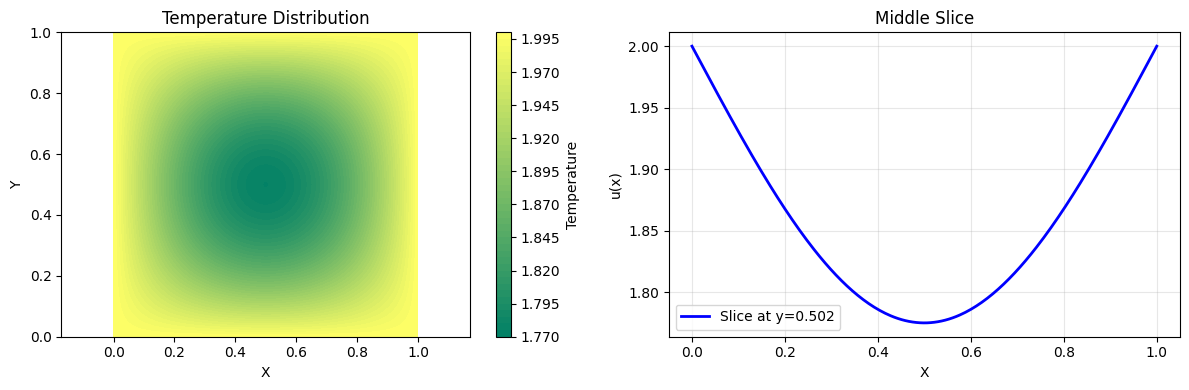

Min temperature: 1.7749
Max temperature: 2.0000
Center temperature: 1.7749


In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def quick_plot():
    try:
        data = np.loadtxt('solution_final.txt', comments='#')
        x = data[:, 0]
        y = data[:, 1]
        u = data[:, 2]

        # Преобразование в сетку
        x_unique = np.unique(x)
        y_unique = np.unique(y)
        nx = len(x_unique)
        ny = len(y_unique)

        u_grid = u.reshape(nx, ny)
        X, Y = np.meshgrid(x_unique, y_unique, indexing='ij')

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        #plt.contourf(X, Y, u_grid, levels=50, cmap='cividis')
        plt.contourf(X, Y, u_grid, levels=50, cmap='summer')
        #plt.contourf(X, Y, u_grid, levels=50, cmap='Reds')
        plt.colorbar(label='Temperature')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Temperature Distribution')
        plt.axis('equal')

        plt.subplot(1, 2, 2)
        middle_y = ny // 2
        plt.plot(x_unique, u_grid[:, middle_y], 'b-', linewidth=2, label=f'Slice at y={y_unique[middle_y]:.3f}')
        plt.xlabel('X')
        plt.ylabel('u(x)')
        plt.title('Middle Slice')
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"Min temperature: {u_grid.min():.4f}")
        print(f"Max temperature: {u_grid.max():.4f}")
        print(f"Center temperature: {u_grid[nx//2, ny//2]:.4f}")

    except Exception as e:
        print(f"Error: {e}")

quick_plot()

### teplo cpu new


In [ ]:
# @title
%%file /tmp/t1v2.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>
#include <algorithm>
#include <chrono>

#define NX 256
#define NY 256
#define DX (1.0/(NX-1))
#define DY (1.0/(NY-1))
#define DX2 (DX*DX)
#define DY2 (DY*DY)
#define C 1.0           // Коэффициент теплопроводности
#define DT (0.25 * fmin(DX*DX, DY*DY) / C) // Условие Куранта

#define NXX16 (NX*1/6)
#define NXX26 (NX*2/6)
#define NXX36 (NX*3/6)
#define NYY16 (NY*1/6)
#define NYY26 (NY*2/6)
#define NYY36 (NY*3/6)

double** allocate_2d_array(int rows, int cols){
    double** a = (double**) malloc(rows*sizeof(double*));
    for (int i=0; i<rows; i++){
        a[i] = (double*) calloc(cols, sizeof(double));//calloc -> 0,..,0
    }
    return a;
}

void free_2_array(double** a, int rows){
    for(int i=0; i<rows;i++){
        free(a[i]);
    }
    free(a);
}

void init_border(double** u){
    //u(X,0) = 1.0 | t=0
    for (int i =0; i<NX; i++){
    for (int ii=0;ii<NY;ii++){
        u[i][ii] = 1.0;
    }
    }
    //u(x,G,T) = 2.0
    for (int i=0; i<NX; i++){
        u[i][0]    =2.0;
        u[i][NY-1] =2.0;
    }
    //u(G,y,T) = 2.0
    for (int i=0; i<NY; i++){
        u[0][i]    =2.0;
        u[NX-1][i] =2.0;
    }
}

void cross_tstep(double** u, double** u_new,double dt){
    //u(x,G,t) = 2.0
    for (int i=0; i<NX; i++){
        u_new[i][0]    =u[i][0]   ;
        u_new[i][NY-1] =u[i][NY-1];
    }
    //u(G,y,t) = 2.0
    for (int i=0; i<NX; i++){
        u_new[0][i]    =u[0][i]   ;
        u_new[NX-1][i] =u[NX-1][i];
    }
    //inner
    for (int i=1; i<NX-1;i++){
    for (int j=1; j<NY-1;j++){
        double laplac = (u[i-1][j] - 2*u[i][j]+ u[i+1][j])/DX2+
                        (u[i][j-1] - 2*u[i][j]+ u[i][j+1])/DY2;
        u_new[i][j] = u[i][j] + dt*C*laplac;

        if (!std::isfinite(u_new[i][j])) { // Проверка на численную устойчивость
            printf("Numerical instability at (%d, %d)! Value = %f\n", i, j, u_new[i][j]);
            return; }
    }
    }
}

void save_to_file(double** u, const char* filename, double t){
  FILE* fp = fopen(filename,"w");
  if(!fp){printf("fp fail\n"); return;}

  fprintf(fp, "# Time: %.6f\n", t);
  fprintf(fp, "# X Y U\n"        );

for(int i=0; i<NX; i++){
for(int j=0; j<NY; j++){
    fprintf(fp, "%.6f %.6f %.6f\n", i*DX, j*DY, u[i][j]);
}
}
  printf("Saved to %s\n", filename);
  fclose(fp);
}

int main(int argc, char* argv[]){
    double time_cur = 0.0;
    double time_end = 0.1;
    int step_cur = 0;

    printf("Solving heat equation until t = %.6f\n", time_end);
    printf("Grid: %dx%d, dx=%.6f, dy=%.6f\n", NX, NY, DX, DY);
    printf("Automatic time step: dt=%.8f (for stability)\n", DT);
    printf("Courant number: %.6f\n", C * DT * (1.0/(DX*DX) + 1.0/(DY*DY)));

    double** u1=allocate_2d_array(NX,NY);
    double** u2=allocate_2d_array(NX,NY);
    init_border(u1);
    init_border(u2);

    printf("Step 0: t = %.6f\n", time_cur);
    auto printtimestart = std::chrono::high_resolution_clock::now();

    while(time_cur<time_end){
        double dt = DT;
        if (time_cur+dt>time_end){
            dt = time_end-time_cur;
            time_cur = time_end;
        }

        cross_tstep(u1,u2,dt);
        std::swap(u1,u2);

        time_cur+=dt;
        step_cur++;

        if (step_cur%1000==0){
          double averdif = 0;
          for (int i=1; i<NX-1;i++){
          for (int j=1; j<NY-1;j++){
          averdif += abs(u1[i][j]-u2[i][j]);
          }
          }
          averdif /= (NX-2)*(NY-2);
          printf("it %d: averdif %.7f\n", step_cur , averdif);
        }

        if (step_cur>1e7){printf("steps oveflw\n"); return 0;}
    }

    auto printtimeended = std::chrono::high_resolution_clock::now();
    auto duration = std::chrono::duration_cast<std::chrono::duration<double>>(printtimeended - printtimestart);
    printf("Time: %.4f seconds\n", duration.count());
    //printf("Time: %.4f\n", printtimeended-printtimestart);
    printf("step_cur: %d\n", step_cur);

    printf("symmetry sliceoy\n");
    printf("%.6f %.6f %.6f\n",u1[NXX16][NYY16],u1[NXX16][NYY26],u1[NXX16][NYY36]);
    printf("%.6f %.6f %.6f\n",u1[NXX16][NY-1-NYY16],u1[NXX16][NY-1-NYY26],u1[NXX16][NY-NYY36]);
    printf("symmetry sliceox\n");
    printf("%.6f %.6f %.6f\n",u1[NXX16][NYY16],u1[NXX26][NYY16],u1[NXX36][NYY16]);
    printf("%.6f %.6f %.6f\n",u1[NX-1-NXX16][NYY16],u1[NX-1-NXX26][NYY16],u1[NX-NXX36][NYY16]);

    save_to_file(u1, "solution_final.txt", time_cur);

    free_2_array(u1,NX);
    free_2_array(u2,NX);
    return -0;
};



Overwriting /tmp/t1v2.cu


In [ ]:
# @title
!nvcc -arch=sm_75 /tmp/t1v2.cu -o /tmp/t1v2
# run the executable with nvprof
!nvprof /tmp/t1v2

Solving heat equation until t = 0.100000
Grid: 256x256, dx=0.003922, dy=0.003922
Automatic time step: dt=0.00000384 (for stability)
Courant number: 0.500000
Step 0: t = 0.000000
it 1000: averdif 0.0001194
it 2000: averdif 0.0000787
it 3000: averdif 0.0000607
it 4000: averdif 0.0000500
it 5000: averdif 0.0000427
it 6000: averdif 0.0000373
it 7000: averdif 0.0000330
it 8000: averdif 0.0000296
it 9000: averdif 0.0000268
it 10000: averdif 0.0000244
it 11000: averdif 0.0000223
it 12000: averdif 0.0000205
it 13000: averdif 0.0000188
it 14000: averdif 0.0000174
it 15000: averdif 0.0000160
it 16000: averdif 0.0000148
it 17000: averdif 0.0000137
it 18000: averdif 0.0000127
it 19000: averdif 0.0000117
it 20000: averdif 0.0000109
it 21000: averdif 0.0000101
it 22000: averdif 0.0000093
it 23000: averdif 0.0000086
it 24000: averdif 0.0000080
it 25000: averdif 0.0000074
it 26000: averdif 0.0000069
Time: 31.8388 seconds
step_cur: 26010
symmetry sliceoy
1.944875 1.903513 1.888603
1.944875 1.903513 1.8

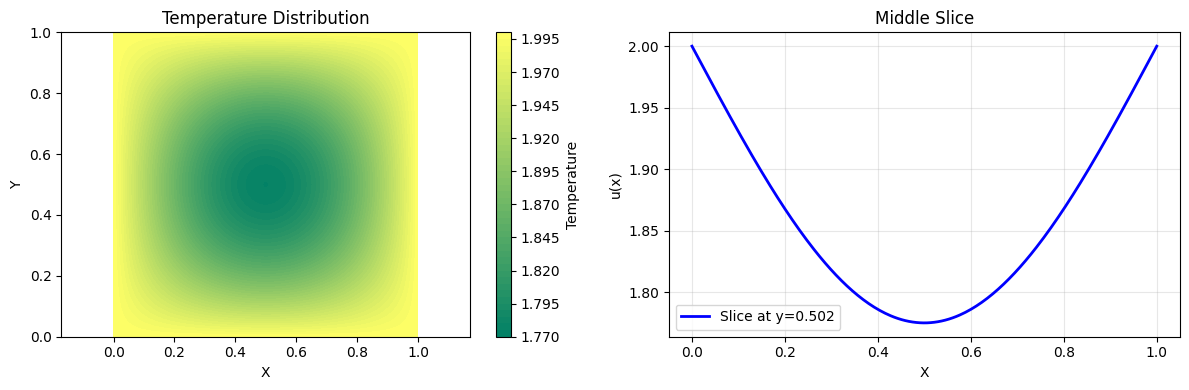

Min temperature: 1.7749
Max temperature: 2.0000
Center temperature: 1.7749


In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def quick_plot():
    try:
        data = np.loadtxt('solution_final.txt', comments='#')
        x = data[:, 0]
        y = data[:, 1]
        u = data[:, 2]

        # Преобразование в сетку
        x_unique = np.unique(x)
        y_unique = np.unique(y)
        nx = len(x_unique)
        ny = len(y_unique)

        u_grid = u.reshape(nx, ny)
        X, Y = np.meshgrid(x_unique, y_unique, indexing='ij')

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        #plt.contourf(X, Y, u_grid, levels=50, cmap='cividis')
        plt.contourf(X, Y, u_grid, levels=50, cmap='summer')
        #plt.contourf(X, Y, u_grid, levels=50, cmap='Reds')
        plt.colorbar(label='Temperature')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Temperature Distribution')
        plt.axis('equal')

        plt.subplot(1, 2, 2)
        middle_y = ny // 2
        plt.plot(x_unique, u_grid[:, middle_y], 'b-', linewidth=2, label=f'Slice at y={y_unique[middle_y]:.3f}')
        plt.xlabel('X')
        plt.ylabel('u(x)')
        plt.title('Middle Slice')
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"Min temperature: {u_grid.min():.4f}")
        print(f"Max temperature: {u_grid.max():.4f}")
        print(f"Center temperature: {u_grid[nx//2, ny//2]:.4f}")

    except Exception as e:
        print(f"Error: {e}")

quick_plot()

gpu

In [ ]:
# @title
%%file /tmp/t2v1.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>
#include <algorithm>
#include <chrono>

// Параметры задачи
#define NX 256
#define NY 256
#define DX (1.0f/(NX-1))
#define DY (1.0f/(NY-1))
#define C 1.0f
#define DT (0.25f * fminf(DX*DX, DY*DY) / C)

// Размер блока------------
#define BLOCK_SIZE 16

#define CHECK_CUDA_ERROR(err) \
if (err != cudaSuccess) { \
     printf("CUDA error: %s at %s:%d\n", cudaGetErrorString(err), __FILE__, __LINE__); \
     exit(1); \
    }


// CUDA kernel для одного шага по времени
__global__ void time_step_kernel(double* u, double* u_new, int width, int height,
                                double dx2, double dy2, double dt_c) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i >= width || j >= height) return;

    int idx = j * width + i;

    // Граничные условия
    if (i == 0 || i == width-1 || j == 0 || j == height-1) {
        u_new[idx] = u[idx];
        return;
    }

    // Вычисление лапласиана для внутренних точек
    double laplacian = (u[idx - 1] - 2*u[idx] + u[idx + 1]) / dx2 +
                      (u[idx - width] - 2*u[idx] + u[idx + width]) / dy2;

    u_new[idx] = u[idx] + dt_c * C * laplacian;
}

// CUDA kernel для инициализации
__global__ void initialize_kernel(double* u, int width, int height) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i >= width || j >= height) return;

    int idx = j * width + i;
    u[idx] = 1.0;

    if (i == 0 || i == width-1 || j == 0 || j == height-1) {
        u[idx] = 2.0;
    }
}

double compute_max_change_cpu(double* u, double* u_new, int width, int height) {
    double max_diff = 0.0;
    for (int j = 1; j < height-1; j++) {
        for (int i = 1; i < width-1; i++) {
            int idx = j * width + i;
            double diff = fabs(u_new[idx] - u[idx]);
            if (diff > max_diff) {
                max_diff = diff;
            }
        }
    }
    return max_diff;
}

double* allocate_gpu_memory(int size) {
    double* ptr;
    CHECK_CUDA_ERROR(cudaMalloc(&ptr, size * sizeof(double)));
    return ptr;
}

void free_gpu_memory(double* ptr) {
    CHECK_CUDA_ERROR(cudaFree(ptr));
}

void copy_between_cpu_gpu(double* dst, double* src, int size, bool to_gpu) {
    cudaMemcpyKind kind = to_gpu ? cudaMemcpyHostToDevice : cudaMemcpyDeviceToHost;
    CHECK_CUDA_ERROR(cudaMemcpy(dst, src, size * sizeof(double), kind));
}

double** allocate_2d_array(int rows, int cols) {
    double** arr = (double**)malloc(rows * sizeof(double*));
    for (int i = 0; i < rows; i++) {
        arr[i] = (double*)calloc(cols, sizeof(double));
    }
    return arr;
}

void free_2d_array(double** arr, int rows) {
    for (int i = 0; i < rows; i++) {
        free(arr[i]);
    }
    free(arr);
}

void save_to_file(double* u, const char* filename, double t, int width, int height) {
    FILE* file = fopen(filename, "w");
    if (!file) {
        printf("Error opening file %s\n", filename);
        return;
    }

    fprintf(file, "# Time: %.6f\n", t);
    fprintf(file, "# X Y U\n");

    for (int i = 0; i < width; i++) {
        for (int j = 0; j < height; j++) {
            int idx = j * width + i;
            fprintf(file, "%.6f %.6f %.6f\n", i*DX, j*DY, u[idx]);
        }
    }

    fclose(file);
    printf("Saved to %s\n", filename);
}

int main() {
    double target_time = 0.1;

    printf("Solving heat equation with CUDA (SYMMETRIC OUTPUT) until t = %.6f\n", target_time);
    printf("Grid: %dx%d, dx=%.6f, dy=%.6f\n", NX, NY, DX, DY);
    printf("Time step: dt=%.8f\n", DT);
    printf("Block size: %dx%d\n", BLOCK_SIZE, BLOCK_SIZE);

    double* h_u = (double*)malloc(NX * NY * sizeof(double));
    double* h_u_new = (double*)malloc(NX * NY * sizeof(double));
    double* d_u = allocate_gpu_memory(NX * NY);
    double* d_u_new = allocate_gpu_memory(NX * NY);

    dim3 blockSize(BLOCK_SIZE, BLOCK_SIZE);
    dim3 gridSize((NX + BLOCK_SIZE - 1) / BLOCK_SIZE,
                  (NY + BLOCK_SIZE - 1) / BLOCK_SIZE);

    printf("Grid size: %dx%d blocks\n", gridSize.x, gridSize.y);

    for (int i = 0; i < NX * NY; i++) {
        h_u[i] = 1.0;
    }
    // Граничные условия
    for (int i = 0; i < NX; i++) {
        h_u[i] = 2.0;
        h_u[(NY-1)*NX + i] = 2.0;
    }
    for (int j = 0; j < NY; j++) {
        h_u[j*NX] = 2.0;
        h_u[j*NX + (NX-1)] = 2.0;
    }

    copy_between_cpu_gpu(d_u, h_u, NX * NY, true);
    copy_between_cpu_gpu(d_u_new, h_u, NX * NY, true);

    double t = 0.0;
    int step = 0;

    printf("Step 0: t = %.6f\n", t);

    auto start_computation = std::chrono::high_resolution_clock::now();
    while (t < target_time) {
        double actual_dt = DT;
        if (t + DT > target_time) {
            actual_dt = target_time - t;
        }

        time_step_kernel<<<gridSize, blockSize>>>(d_u, d_u_new, NX, NY, DX*DX, DY*DY, actual_dt);
        CHECK_CUDA_ERROR(cudaDeviceSynchronize());

        std::swap(d_u, d_u_new);
        t += actual_dt;
        step++;

        // Проверка максимального изменения каждые 1000 шагов
        if (step % 1000 == 0) {
            // Копируем оба массива на CPU для вычисления max_change
            copy_between_cpu_gpu(h_u, d_u, NX * NY, false);
            copy_between_cpu_gpu(h_u_new, d_u_new, NX * NY, false);

            double max_diff = compute_max_change_cpu(h_u, h_u_new, NX, NY);
            printf("Step %d: t = %.6f, max change = %.8f\n", step, t, max_diff);
        }

        if (step > 1000000) {
            printf("Too many steps, possible instability!\n");
            break;
        }
    }

    auto end_computation = std::chrono::high_resolution_clock::now();

    printf("Final: step %d, t = %.6f\n", step, t);

    // Копируем результат обратно на CPU
    copy_between_cpu_gpu(h_u, d_u, NX * NY, false);
    save_to_file(h_u, "solution_final_cuda_symmetric.txt", t, NX, NY);

    printf("\nSymmetric slice at y = %d (middle):\n", NY/2);
    printf("Left part (from center to left boundary):\n");
    for (int offset = 0; offset <= NX/2; offset += NX/16) {
        int left_idx = (NY/2) * NX + (NX/2 - offset);
        int right_idx = (NY/2) * NX + (NX/2 + offset);
        printf("  u[%3d][%3d] = %8.6f  |  u[%3d][%3d] = %8.6f\n",
               NX/2 - offset, NY/2, h_u[left_idx],
               NX/2 + offset, NY/2, h_u[right_idx]);
    }

    // Проверка симметрии более детально
    printf("\nDetailed symmetry check around center:\n");
    int center = NX / 2;
    for (int offset = 1; offset <= 5; offset++) {
        int left_idx = (NY/2) * NX + (center - offset);
        int right_idx = (NY/2) * NX + (center + offset);
        double left_val = h_u[left_idx];
        double right_val = h_u[right_idx];
        double symmetry_error = fabs(left_val - right_val);
        printf("  Offset %d: u[%d]=%.6f, u[%d]=%.6f, error=%.8f\n",
               offset, center-offset, left_val, center+offset, right_val, symmetry_error);
    }

    printf("\nBoundary check:\n");
    printf("Top-left corner:     u[0][%d] = %.6f (should be 2.0)\n", NY-1, h_u[(NY-1)*NX + 0]);
    printf("Center:              u[%d][%d] = %.6f\n", NX/2, NY/2, h_u[(NY/2)*NX + NX/2]);
    printf("Bottom-right corner: u[%d][0] = %.6f (should be 2.0)\n", NX-1, h_u[0*NX + (NX-1)]);

    auto computation_time = std::chrono::duration_cast<std::chrono::microseconds>(end_computation - start_computation);
    printf("\n=== CUDA Performance Results ===\n");
    printf("Computation time: %.3f ms\n", computation_time.count() / 1000.0);
    printf("Time per step: %.3f microseconds\n", computation_time.count() / (double)step);

    free(h_u);
    free(h_u_new);
    free_gpu_memory(d_u);
    free_gpu_memory(d_u_new);

    return 0;
}

Overwriting /tmp/t2v1.cu


In [ ]:
# @title
!nvcc -arch=sm_75 /tmp/t2v1.cu -o /tmp/t2v1
# run the executable with nvprof
!nvprof /tmp/t2v1

Solving heat equation with CUDA (SYMMETRIC OUTPUT) until t = 0.100000
Grid: 256x256, dx=0.003922, dy=0.003922
Time step: dt=0.00000384
Block size: 16x16
==1026== NVPROF is profiling process 1026, command: /tmp/t2v1
Grid size: 16x16 blocks
Step 0: t = 0.000000
Step 1000: t = 0.003845, max change = 0.00036008
Step 2000: t = 0.007689, max change = 0.00018007
Step 3000: t = 0.011534, max change = 0.00012005
Step 4000: t = 0.015379, max change = 0.00009007
Step 5000: t = 0.019223, max change = 0.00007232
Step 6000: t = 0.023068, max change = 0.00006113
Step 7000: t = 0.026913, max change = 0.00005419
Step 8000: t = 0.030757, max change = 0.00005036
Step 9000: t = 0.034602, max change = 0.00004903
Step 10000: t = 0.038447, max change = 0.00004854
Step 11000: t = 0.042291, max change = 0.00004716
Step 12000: t = 0.046136, max change = 0.00004521
Step 13000: t = 0.049981, max change = 0.00004294
Step 14000: t = 0.053825, max change = 0.00004051
Step 15000: t = 0.057670, max change = 0.00003803

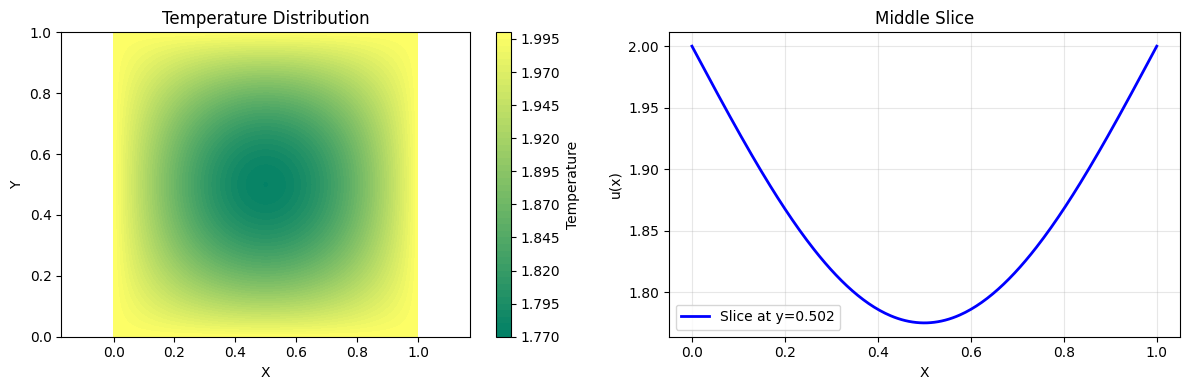

Min temperature: 1.7749
Max temperature: 2.0000
Center temperature: 1.7749


In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def quick_plot1():
    try:
        data = np.loadtxt('solution_final_cuda_symmetric.txt', comments='#')
        x = data[:, 0]
        y = data[:, 1]
        u = data[:, 2]

        # Преобразование в сетку
        x_unique = np.unique(x)
        y_unique = np.unique(y)
        nx = len(x_unique)
        ny = len(y_unique)

        u_grid = u.reshape(nx, ny)
        X, Y = np.meshgrid(x_unique, y_unique, indexing='ij')

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        #plt.contourf(X, Y, u_grid, levels=50, cmap='cividis')
        plt.contourf(X, Y, u_grid, levels=50, cmap='summer')
        #plt.contourf(X, Y, u_grid, levels=50, cmap='Reds')
        plt.colorbar(label='Temperature')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Temperature Distribution')
        plt.axis('equal')

        plt.subplot(1, 2, 2)
        middle_y = ny // 2
        plt.plot(x_unique, u_grid[:, middle_y], 'b-', linewidth=2, label=f'Slice at y={y_unique[middle_y]:.3f}')
        plt.xlabel('X')
        plt.ylabel('u(x)')
        plt.title('Middle Slice')
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"Min temperature: {u_grid.min():.4f}")
        print(f"Max temperature: {u_grid.max():.4f}")
        print(f"Center temperature: {u_grid[nx//2, ny//2]:.4f}")

    except Exception as e:
        print(f"Error: {e}")

quick_plot1()

# urmat laplac

cpu


In [ ]:
# @title
%%file /tmp/t1v1.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>
#include <algorithm>
#include <chrono>

// Параметры задачи
//#define NX 256           // Количество узлов по x
//#define NY 256           // Количество узлов по y
#define NX 128           // Количество узлов по x
#define NY 128           // Количество узлов по y
#define DX (1.0/(NX-1)) // Шаг по пространству
#define DY (1.0/(NY-1))
#define MAX_ITER 50000   // Максимальное количество итераций
#define TOLERANCE 1e-5   // Точность решения

double** allocate_2d_array(int rows, int cols) {
    double** arr = (double**)malloc(rows * sizeof(double*));
    for (int i = 0; i < rows; i++) {
        arr[i] = (double*)calloc(cols, sizeof(double));
    }
    return arr;
}

void free_2d_array(double** arr, int rows) {
    for (int i = 0; i < rows; i++) {
        free(arr[i]);
    }
    free(arr);
}

// Инициализация начальных и граничных условий
void initialize(double** u) {
    // Внутренняя область инициализируется нулями
    for (int i = 0; i < NX; i++) {
        for (int j = 0; j < NY; j++) {
            u[i][j] = 0.0;
        }
    }

    // Граничные условия из новой задачи
    for (int i = 0; i < NX; i++) {
        u[i][0] = exp(1.0 - i*DX);    // u(x,0) = e^(1-x)
        u[i][NY-1] = 1.0;             // u(x,1) = 1.0
    }

    for (int j = 0; j < NY; j++) {
        u[0][j] = exp(1.0 - j*DY);    // u(0,y) = e^(1-y)
        u[NX-1][j] = 1.0;             // u(1,y) = 1.0
    }
}

// Простой метод Якоби для уравнения Лапласа
void jacobi_step(double** u, double** u_new) {
    double dx2 = DX * DX;
    double dy2 = DY * DY;
    double factor = 0.5 / (1.0/dx2 + 1.0/dy2);

    // Копируем граничные условия
    for (int i = 0; i < NX; i++) {
        u_new[i][0] = u[i][0];
        u_new[i][NY-1] = u[i][NY-1];
    }
    for (int j = 0; j < NY; j++) {
        u_new[0][j] = u[0][j];
        u_new[NX-1][j] = u[NX-1][j];
    }

    // Вычисление новых значений во внутренних точках
    for (int i = 1; i < NX - 1; i++) {
        for (int j = 1; j < NY - 1; j++) {
            u_new[i][j] = factor * (
                (u[i-1][j] + u[i+1][j]) / dx2 +
                (u[i][j-1] + u[i][j+1]) / dy2
            );
        }
    }
}

// Вычисление максимального изменения за шаг
double max_change(double** u, double** u_new) {
    double max_diff = 0.0;
    for (int i = 1; i < NX - 1; i++) {
        for (int j = 1; j < NY - 1; j++) {
            double diff = fabs(u_new[i][j] - u[i][j]);
            if (diff > max_diff) {
                max_diff = diff;
            }
        }
    }
    return max_diff;
}

// Вычисление невязки (норма C)//------------------------------------------------------------------------
double compute_residual(double** u) {
    double max_residual = 0.0;
    double dx2 = DX * DX;
    double dy2 = DY * DY;

    for (int i = 1; i < NX - 1; i++) {
        for (int j = 1; j < NY - 1; j++) {
            double residual = fabs(
                (u[i-1][j] - 2*u[i][j] + u[i+1][j]) / dx2 +
                (u[i][j-1] - 2*u[i][j] + u[i][j+1]) / dy2
            );
            if (residual > max_residual) {
                max_residual = residual;
            }
        }
    }
    return max_residual;
}

// Вычисление нормы L1
double compute_l1_norm(double** u) {
    double sum = 0.0;
    for (int i = 0; i < NX; i++) {
        for (int j = 0; j < NY; j++) {
            sum += fabs(u[i][j]);
        }
    }
    return sum * DX * DY;
}

void save_to_file(double** u, const char* filename) {
    FILE* file = fopen(filename, "w");
    if (!file) {
        printf("Error opening file %s\n", filename);
        return;
    }

    fprintf(file, "# X Y U\n");
    for (int i = 0; i < NX; i++) {
        for (int j = 0; j < NY; j++) {
            fprintf(file, "%.6f %.6f %.6f\n", i*DX, j*DY, u[i][j]);
        }
    }

    fclose(file);
    printf("Saved to %s\n", filename);
}

int main(int argc, char* argv[]) {
    printf("Solving Laplace equation: d²u/dx² + d²u/dy² = 0\n");
    printf("Grid: %dx%d, dx=%.6f, dy=%.6f\n", NX, NY, DX, DY);
    printf("Tolerance: %.2e, Max iterations: %d\n", TOLERANCE, MAX_ITER);

    double** u_current = allocate_2d_array(NX, NY);
    double** u_next = allocate_2d_array(NX, NY);
    initialize(u_current);
    initialize(u_next);

    auto start_computation = std::chrono::high_resolution_clock::now();

    // Основной итерационный цикл
    int iter = 0;
    double max_diff = 0.0;
    double residual = 0.0;

    printf("\nStarting iterations...\n");
    printf("Iter  Residual(C-norm)    Max-Change      L1-Norm\n");
    printf("--------------------------------------------------\n");

    for (iter = 1; iter <= MAX_ITER; iter++) {
        jacobi_step(u_current, u_next);

        max_diff = max_change(u_current, u_next);
        residual = compute_residual(u_next);
        double l1_norm = compute_l1_norm(u_next);

        std::swap(u_current, u_next);

        // Вывод прогресса каждые 1000 итераций
        if (iter % 1000 == 0) {
            printf("%5d  %12.6e  %12.6e  %12.6e\n",
                   iter, residual, max_diff, l1_norm);
        }

        // Критерий остановки
        if (residual < TOLERANCE && max_diff < TOLERANCE) {
            printf("%5d  %12.6e  %12.6e  %12.6e\n",
                   iter, residual, max_diff, l1_norm);
            printf("Converged!\n");
            break;
        }
    }

    auto end_computation = std::chrono::high_resolution_clock::now();

    if (iter > MAX_ITER) {
        printf("Reached maximum iterations without convergence\n");
        printf("Current residual: %.6e (target: %.1e)\n", residual, TOLERANCE);
    }

    printf("\n=== Final Results ===\n");
    printf("Iterations: %d\n", iter);
    printf("Final residual (C-norm): %.6e\n", residual);
    printf("Final max change: %.6e\n", max_diff);
    printf("Final L1 norm: %.6e\n", compute_l1_norm(u_current));

    save_to_file(u_current, "solution_laplace.txt");

    // Анализ решения
    printf("\n=== Solution Analysis ===\n");

    // Проверка граничных условий
    printf("Boundary conditions check:\n");
    printf("u(0,0) = %.6f (should be e = %.6f)\n", u_current[0][0], exp(1.0));
    printf("u(1,0) = %.6f (should be 1.0)\n", u_current[NX-1][0]);
    printf("u(0,1) = %.6f (should be 1.0)\n", u_current[0][NY-1]);
    printf("u(1,1) = %.6f (should be 1.0)\n", u_current[NX-1][NY-1]);

    // Проверка внутренних точек
    printf("\nInternal points:\n");
    printf("u(0.5, 0.5) = %.6f\n", u_current[NX/2][NY/2]);
    printf("u(0.25, 0.25) = %.6f\n", u_current[NX/4][NY/4]);
    printf("u(0.75, 0.75) = %.6f\n", u_current[3*NX/4][3*NY/4]);

    auto computation_time = std::chrono::duration_cast<std::chrono::microseconds>(end_computation - start_computation);
    printf("\n=== Performance Results ===\n");
    printf("Total computation time: %.3f ms\n", computation_time.count() / 1000.0);
    printf("Time per iteration: %.3f microseconds\n", computation_time.count() / (double)iter);
    printf("Iterations per second: %.0f\n", iter / (computation_time.count() / 1000000.0));

    free_2d_array(u_current, NX);
    free_2d_array(u_next, NX);

    return 0;
}

Overwriting /tmp/t1v1.cu


In [ ]:
# @title
!nvcc -arch=sm_75 /tmp/t1v1.cu -o /tmp/t1v1
# run the executable with nvprof
!nvprof /tmp/t1v1

Solving Laplace equation: d²u/dx² + d²u/dy² = 0
Grid: 128x128, dx=0.007874, dy=0.007874
Tolerance: 1.00e-05, Max iterations: 50000

Starting iterations...
Iter  Residual(C-norm)    Max-Change      L1-Norm
--------------------------------------------------
 1000  4.825725e+01  7.485691e-04  6.747362e-01
 2000  2.282065e+01  3.537575e-04  8.815974e-01
 3000  1.647062e+01  2.553533e-04  1.015109e+00
 4000  1.249145e+01  1.936543e-04  1.109617e+00
 5000  9.287306e+00  1.439822e-04  1.178395e+00
 6000  6.855223e+00  1.062780e-04  1.228867e+00
 7000  5.049931e+00  7.829375e-05  1.265995e+00
 8000  3.719094e+00  5.765806e-05  1.293328e+00
 9000  2.738657e+00  4.245810e-05  1.313454e+00
10000  2.016613e+00  3.126406e-05  1.328275e+00
11000  1.484947e+00  2.302152e-05  1.339188e+00
12000  1.093468e+00  1.695284e-05  1.347225e+00
13000  8.052044e-01  1.248398e-05  1.353143e+00
14000  5.929389e-01  9.193138e-06  1.357501e+00
15000  4.366326e-01  6.769775e-06  1.360711e+00
16000  3.215317e-01  4.9

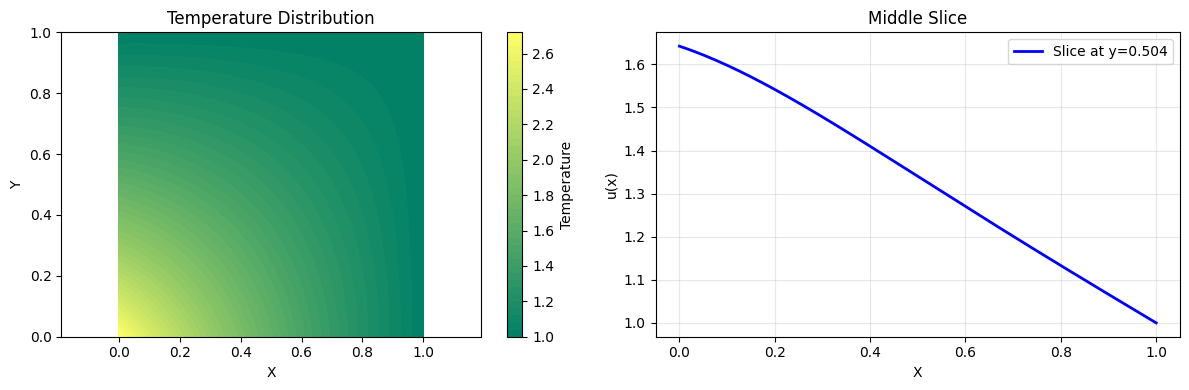

Min temperature: 1.0000
Max temperature: 2.7183
Center temperature: 1.3374


In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def quick_plot():
    try:
        data = np.loadtxt('solution_laplace.txt', comments='#')
        x = data[:, 0]
        y = data[:, 1]
        u = data[:, 2]

        # Преобразование в сетку
        x_unique = np.unique(x)
        y_unique = np.unique(y)
        nx = len(x_unique)
        ny = len(y_unique)

        u_grid = u.reshape(nx, ny)
        X, Y = np.meshgrid(x_unique, y_unique, indexing='ij')

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        #plt.contourf(X, Y, u_grid, levels=50, cmap='cividis')
        plt.contourf(X, Y, u_grid, levels=50, cmap='summer')
        #plt.contourf(X, Y, u_grid, levels=50, cmap='Reds')
        plt.colorbar(label='Temperature')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Temperature Distribution')
        plt.axis('equal')

        plt.subplot(1, 2, 2)
        middle_y = ny // 2
        plt.plot(x_unique, u_grid[:, middle_y], 'b-', linewidth=2, label=f'Slice at y={y_unique[middle_y]:.3f}')
        plt.xlabel('X')
        plt.ylabel('u(x)')
        plt.title('Middle Slice')
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"Min temperature: {u_grid.min():.4f}")
        print(f"Max temperature: {u_grid.max():.4f}")
        print(f"Center temperature: {u_grid[nx//2, ny//2]:.4f}")

    except Exception as e:
        print(f"Error: {e}")

quick_plot()

gpu

In [ ]:
# @title
%%file /tmp/t2v1.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>
#include <thrust/device_ptr.h>
#include <thrust/reduce.h>
#include <thrust/functional.h>
#include <algorithm>
#include <chrono>

// Параметры задачи (как в CPU версии)
#define NX 128           // Количество узлов по x
#define NY 128           // Количество узлов по y
#define DX (1.0/(NX-1)) // Шаг по пространству
#define DY (1.0/(NY-1))
#define MAX_ITER 50000   // Максимальное количество итераций
#define TOLERANCE 1e-5   // Точность решения

// Размер блока
#define BLOCK_SIZE 16

#define CHECK_CUDA_ERROR(err) \
    if (err != cudaSuccess) { \
        printf("CUDA error: %s at %s:%d\n", cudaGetErrorString(err), __FILE__, __LINE__); \
        exit(1); \
    }

// CUDA kernel для одного шага Якоби
__global__ void jacobi_step_kernel(const double* u, double* u_new, int width, int height) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i >= 1 && i < width-1 && j >= 1 && j < height-1) {
        int idx = j * width + i;

        double dx2 = DX * DX;
        double dy2 = DY * DY;
        double factor = 0.5 / (1.0/dx2 + 1.0/dy2);

        double left = u[idx - 1];
        double right = u[idx + 1];
        double bottom = u[idx - width];
        double top = u[idx + width];

        u_new[idx] = factor * ((left + right) / dx2 + (bottom + top) / dy2);
    }
}

// CUDA kernel для вычисления невязки (норма C)
__global__ void compute_residual_kernel(const double* u, double* residual, int width, int height) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i >= 1 && i < width-1 && j >= 1 && j < height-1) {
        int idx = j * width + i;

        double dx2 = DX * DX;
        double dy2 = DY * DY;

        double laplacian = (u[idx - 1] - 2*u[idx] + u[idx + 1]) / dx2 +
                          (u[idx - width] - 2*u[idx] + u[idx + width]) / dy2;

        residual[idx] = fabs(laplacian);
    } else {
        // Для граничных точек невязка = 0
        int idx = j * width + i;
        residual[idx] = 0.0;
    }
}

// CUDA kernel для копирования граничных условий
__global__ void copy_boundaries_kernel(const double* u, double* u_new, int width, int height) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i >= width || j >= height) return;

    int idx = j * width + i;

    // Копируем граничные условия
    if (i == 0 || i == width-1 || j == 0 || j == height-1) {
        u_new[idx] = u[idx];
    }
}

// CUDA kernel для инициализации граничных условий
__global__ void initialize_boundaries_kernel(double* u, int width, int height) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i >= width || j >= height) return;

    int idx = j * width + i;

    // Нижняя граница: u(x,0) = e^(1-x)
    if (j == 0) {
        u[idx] = exp(1.0 - i * DX);
    }
    // Верхняя граница: u(x,1) = 1.0
    else if (j == height-1) {
        u[idx] = 1.0;
    }
    // Левая граница: u(0,y) = e^(1-y)
    else if (i == 0) {
        u[idx] = exp(1.0 - j * DY);
    }
    // Правая граница: u(1,y) = 1.0
    else if (i == width-1) {
        u[idx] = 1.0;
    }
    // Внутренние точки
    else {
        u[idx] = 0.0;
    }
}

// Kernel для вычисления разностей между массивами
__global__ void compute_diff_kernel(const double* a, const double* b, double* diff, int size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < size) {
        diff[idx] = fabs(a[idx] - b[idx]);
    }
}

// Функция для вычисления нормы C (максимум) с использованием Thrust
double compute_norm_c(const double* d_data, int size) {
    thrust::device_ptr<const double> thrust_ptr(d_data);
    return thrust::reduce(thrust_ptr, thrust_ptr + size, 0.0, thrust::maximum<double>());
}

// Функция для вычисления нормы L1 с использованием Thrust
double compute_norm_l1(const double* d_data, int size) {
    thrust::device_ptr<const double> thrust_ptr(d_data);
    double sum = thrust::reduce(thrust_ptr, thrust_ptr + size, 0.0, thrust::plus<double>());
    return sum * DX * DY;
}

// Функция для вычисления максимального изменения между итерациями
double compute_max_change(const double* d_u, const double* d_u_new, int size) {
    // Выделяем память для разностей
    double* d_diff;
    CHECK_CUDA_ERROR(cudaMalloc(&d_diff, size * sizeof(double)));

    // Вычисляем разности
    int blockSize1D = 256;
    int gridSize1D = (size + blockSize1D - 1) / blockSize1D;
    compute_diff_kernel<<<gridSize1D, blockSize1D>>>(d_u, d_u_new, d_diff, size);
    CHECK_CUDA_ERROR(cudaDeviceSynchronize());

    // Находим максимум с помощью Thrust
    double max_diff = compute_norm_c(d_diff, size);

    // Освобождаем память
    cudaFree(d_diff);

    return max_diff;
}

// Функция для вычисления невязки (норма C)
double compute_residual(const double* d_u, int width, int height) {
    // Выделяем память для невязки
    double* d_residual;
    CHECK_CUDA_ERROR(cudaMalloc(&d_residual, width * height * sizeof(double)));

    // Настройка размеров блоков и гридов
    dim3 blockSize(BLOCK_SIZE, BLOCK_SIZE);
    dim3 gridSize((width + BLOCK_SIZE - 1) / BLOCK_SIZE,
                  (height + BLOCK_SIZE - 1) / BLOCK_SIZE);

    // Вычисляем невязку
    compute_residual_kernel<<<gridSize, blockSize>>>(d_u, d_residual, width, height);
    CHECK_CUDA_ERROR(cudaDeviceSynchronize());

    // Находим максимальную невязку
    double max_residual = compute_norm_c(d_residual, width * height);

    // Освобождаем память
    cudaFree(d_residual);

    return max_residual;
}

int main() {
    printf("Solving Laplace equation with CUDA\n");
    printf("Grid: %dx%d, dx=%.6f, dy=%.6f\n", NX, NY, DX, DY);
    printf("Tolerance: %.2e, Max iterations: %d\n", TOLERANCE, MAX_ITER);
    printf("Block size: %dx%d\n", BLOCK_SIZE, BLOCK_SIZE);

    // Выделение памяти на GPU
    double *d_u, *d_u_new;
    CHECK_CUDA_ERROR(cudaMalloc(&d_u, NX * NY * sizeof(double)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_u_new, NX * NY * sizeof(double)));

    // Выделение памяти на CPU для вывода
    double* h_u = (double*)malloc(NX * NY * sizeof(double));

    // Настройка размеров блоков и гридов
    dim3 blockSize(BLOCK_SIZE, BLOCK_SIZE);
    dim3 gridSize((NX + BLOCK_SIZE - 1) / BLOCK_SIZE,
                  (NY + BLOCK_SIZE - 1) / BLOCK_SIZE);

    printf("Grid size: %dx%d blocks\n", gridSize.x, gridSize.y);

    // Инициализация
    initialize_boundaries_kernel<<<gridSize, blockSize>>>(d_u, NX, NY);
    initialize_boundaries_kernel<<<gridSize, blockSize>>>(d_u_new, NX, NY);
    CHECK_CUDA_ERROR(cudaDeviceSynchronize());

    auto start_computation = std::chrono::high_resolution_clock::now();

    // Основной итерационный цикл
    int iter = 0;
    double residual = 0.0;
    double max_change_val = 0.0;

    printf("\nStarting iterations...\n");
    printf("Iter  Residual(C-norm)    Max-Change      L1-Norm\n");
    printf("--------------------------------------------------\n");

    for (iter = 1; iter <= MAX_ITER; iter++) {
        // Шаг Якоби
        jacobi_step_kernel<<<gridSize, blockSize>>>(d_u, d_u_new, NX, NY);
        CHECK_CUDA_ERROR(cudaDeviceSynchronize());

        // Копируем граничные условия
        copy_boundaries_kernel<<<gridSize, blockSize>>>(d_u, d_u_new, NX, NY);
        CHECK_CUDA_ERROR(cudaDeviceSynchronize());

        // Вычисляем невязку и изменения
        residual = compute_residual(d_u_new, NX, NY);
        max_change_val = compute_max_change(d_u, d_u_new, NX * NY);
        double l1_norm = compute_norm_l1(d_u_new, NX * NY);

        // Меняем массивы местами
        std::swap(d_u, d_u_new);

        // Вывод прогресса каждые 1000 итераций
        if (iter % 1000 == 0) {
            printf("%5d  %12.6e  %12.6e  %12.6e\n",
                   iter, residual, max_change_val, l1_norm);
        }

        // Критерий остановки (как в CPU версии)
        if (residual < TOLERANCE && max_change_val < TOLERANCE) {
            printf("%5d  %12.6e  %12.6e  %12.6e\n",
                   iter, residual, max_change_val, l1_norm);
            printf("Converged!\n");
            break;
        }
    }

    auto end_computation = std::chrono::high_resolution_clock::now();

    if (iter > MAX_ITER) {
        printf("Reached maximum iterations without convergence\n");
        printf("Current residual: %.6e (target: %.1e)\n", residual, TOLERANCE);
    }

    // Копируем результат обратно на CPU
    CHECK_CUDA_ERROR(cudaMemcpy(h_u, d_u, NX * NY * sizeof(double), cudaMemcpyDeviceToHost));

    // Вывод результатов
    printf("\n=== Final Results ===\n");
    printf("Iterations: %d\n", iter);
    printf("Final residual (C-norm): %.6e\n", residual);
    printf("Final max change: %.6e\n", max_change_val);
    printf("Final L1 norm: %.6e\n", compute_norm_l1(d_u, NX * NY));

    // Сохранение в файл
    FILE* file = fopen("solution_laplace_cuda.txt", "w");
    if (file) {
        fprintf(file, "# X Y U\n");
        for (int j = 0; j < NY; j++) {
            for (int i = 0; i < NX; i++) {
                int idx = j * NX + i;
                fprintf(file, "%.6f %.6f %.6f\n", i*DX, j*DY, h_u[idx]);
            }
        }
        fclose(file);
        printf("Saved to solution_laplace_cuda.txt\n");
    }

    // Анализ решения
    printf("\n=== Solution Analysis ===\n");
    printf("Boundary conditions check:\n");
    printf("u(0,0) = %.6f (should be e = %.6f)\n", h_u[0], exp(1.0));
    printf("u(1,0) = %.6f (should be 1.0)\n", h_u[NY-1], 1.0);
    printf("u(0,1) = %.6f (should be 1.0)\n", h_u[(NY-1)*NX], 1.0);
    printf("u(1,1) = %.6f (should be 1.0)\n", h_u[NY*NX-1], 1.0);

    printf("\nInternal points:\n");
    printf("u(0.5, 0.5) = %.6f\n", h_u[(NY/2)*NX + NX/2]);
    printf("u(0.25, 0.25) = %.6f\n", h_u[(NY/4)*NX + NX/4]);
    printf("u(0.75, 0.75) = %.6f\n", h_u[(3*NY/4)*NX + 3*NX/4]);

    auto computation_time = std::chrono::duration_cast<std::chrono::microseconds>(
        end_computation - start_computation);

    printf("\n=== CUDA Performance Results ===\n");
    printf("Total computation time: %.3f ms\n", computation_time.count() / 1000.0);
    printf("Time per iteration: %.3f microseconds\n", computation_time.count() / (double)iter);
    printf("Iterations per second: %.0f\n", iter / (computation_time.count() / 1000000.0));

    // Освобождение памяти
    free(h_u);
    cudaFree(d_u);
    cudaFree(d_u_new);

    return 0;
}

Overwriting /tmp/t2v1.cu


In [ ]:
# @title
!nvcc -arch=sm_75 /tmp/t2v1.cu -o /tmp/t2v1
# run the executable with nvprof
!nvprof /tmp/t2v1

/tmp/t2v1.cu(289): warning #225-D: the format string ends before this argument
      printf("u(1,0) = %.6f (should be 1.0)\n", h_u[128 -1], 1.0);
                                                             ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/tmp/t2v1.cu(290): warning #225-D: the format string ends before this argument
      printf("u(0,1) = %.6f (should be 1.0)\n", h_u[(128 -1)*128], 1.0);
                                                                   ^

/tmp/t2v1.cu(291): warning #225-D: the format string ends before this argument
      printf("u(1,1) = %.6f (should be 1.0)\n", h_u[128*128 -1], 1.0);
                                                                 ^

/tmp/t2v1.cu: In function ‘int main()’:
/tmp/t2v1.cu:289:8: warning: too many arguments for format []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wformat-extra-args-Wformat-extra-args]8;;]
  289 |     printf("u(1,0) = %.6f (should be 1.0)\n", h_u[

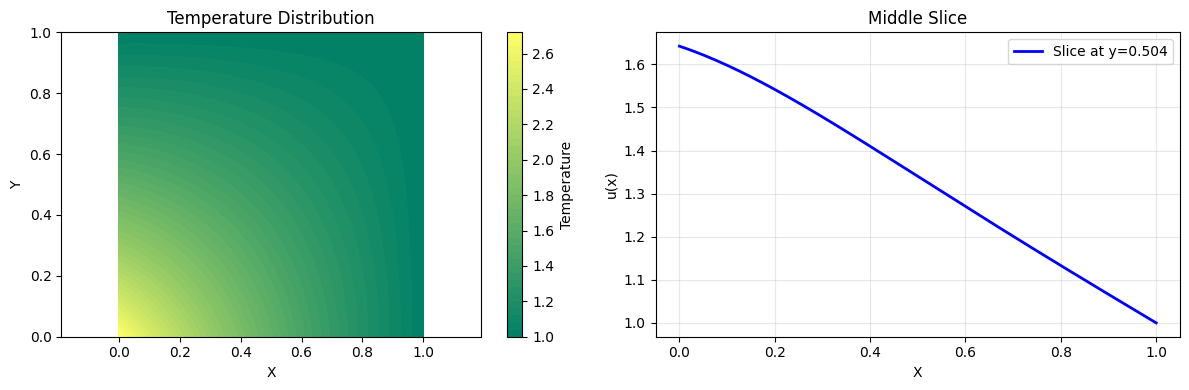

Min temperature: 1.0000
Max temperature: 2.7183
Center temperature: 1.3374


In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def quick_plot1():
    try:
        data = np.loadtxt('solution_laplace_cuda.txt', comments='#')
        x = data[:, 0]
        y = data[:, 1]
        u = data[:, 2]

        # Преобразование в сетку
        x_unique = np.unique(x)
        y_unique = np.unique(y)
        nx = len(x_unique)
        ny = len(y_unique)

        u_grid = u.reshape(nx, ny)
        X, Y = np.meshgrid(x_unique, y_unique, indexing='ij')

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        #plt.contourf(X, Y, u_grid, levels=50, cmap='cividis')
        plt.contourf(X, Y, u_grid, levels=50, cmap='summer')
        #plt.contourf(X, Y, u_grid, levels=50, cmap='Reds')
        plt.colorbar(label='Temperature')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Temperature Distribution')
        plt.axis('equal')

        plt.subplot(1, 2, 2)
        middle_y = ny // 2
        plt.plot(x_unique, u_grid[:, middle_y], 'b-', linewidth=2, label=f'Slice at y={y_unique[middle_y]:.3f}')
        plt.xlabel('X')
        plt.ylabel('u(x)')
        plt.title('Middle Slice')
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"Min temperature: {u_grid.min():.4f}")
        print(f"Max temperature: {u_grid.max():.4f}")
        print(f"Center temperature: {u_grid[nx//2, ny//2]:.4f}")

    except Exception as e:
        print(f"Error: {e}")

quick_plot1()

new

In [ ]:
%%file /tmp/t2v1_simple.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>
#include <algorithm>
#include <chrono>

// Параметры задачи
#define NX 128
#define NY 128
#define DX (1.0/(NX-1))
#define DY (1.0/(NY-1))
#define MAX_ITER 50000
#define TOLERANCE 1e-5

#define BLOCK_SIZE 16

#define CHECK_CUDA_ERROR(err) \
    if (err != cudaSuccess) { \
        printf("CUDA error: %s at %s:%d\n", cudaGetErrorString(err), __FILE__, __LINE__); \
        exit(1); \
    }

// Ядро Якоби
__global__ void jacobi_step_kernel(const double* u, double* u_new, int width, int height) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i >= 1 && i < width-1 && j >= 1 && j < height-1) {
        int idx = j * width + i;
        double dx2 = DX * DX;
        double dy2 = DY * DY;
        double factor = 0.5 / (1.0/dx2 + 1.0/dy2);
        u_new[idx] = factor * ((u[idx - 1] + u[idx + 1]) / dx2 + (u[idx - width] + u[idx + width]) / dy2);
    }
}

// Ядро невязки
__global__ void compute_residual_kernel(const double* u, double* residual, int width, int height) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i >= width || j >= height) return;
    int idx = j * width + i;

    if (i >= 1 && i < width-1 && j >= 1 && j < height-1) {
        double dx2 = DX * DX;
        double dy2 = DY * DY;
        double laplacian = (u[idx - 1] - 2*u[idx] + u[idx + 1]) / dx2 +
                          (u[idx - width] - 2*u[idx] + u[idx + width]) / dy2;
        residual[idx] = fabs(laplacian);
    } else {
        residual[idx] = 0.0;
    }
}

// Копирование граничных условий
__global__ void copy_boundaries_kernel(const double* u, double* u_new, int width, int height) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    if (i >= width || j >= height) return;
    int idx = j * width + i;
    if (i == 0 || i == width-1 || j == 0 || j == height-1) {
        u_new[idx] = u[idx];
    }
}

// Инициализация граничных условий
__global__ void initialize_boundaries_kernel(double* u, int width, int height) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    if (i >= width || j >= height) return;
    int idx = j * width + i;

    if (j == 0) u[idx] = exp(1.0 - i * DX);
    else if (j == height-1) u[idx] = 1.0;
    else if (i == 0) u[idx] = exp(1.0 - j * DY);
    else if (i == width-1) u[idx] = 1.0;
    else u[idx] = 0.0;
}

// CPU-функции для норм
double compute_norm_c_cpu(const double* data, int size) {
    double max_val = 0.0;
    for (int i = 0; i < size; i++) {
        if (data[i] > max_val) max_val = data[i];
    }
    return max_val;
}

double compute_norm_l1_cpu(const double* data, int size) {
    double sum = 0.0;
    for (int i = 0; i < size; i++) {
        sum += data[i];
    }
    return sum * DX * DY;
}

double compute_max_change_cpu(const double* a, const double* b, int size) {
    double max_diff = 0.0;
    for (int i = 0; i < size; i++) {
        double diff = fabs(a[i] - b[i]);
        if (diff > max_diff) max_diff = diff;
    }
    return max_diff;
}

int main() {
    printf("Solving Laplace equation with CUDA (simple version, no Thrust)\n");
    printf("Grid: %dx%d, dx=%.6f, dy=%.6f\n", NX, NY, DX, DY);
    printf("Tolerance: %.2e, Max iterations: %d\n", TOLERANCE, MAX_ITER);

    // Выделение памяти на GPU
    double *d_u, *d_u_new;
    CHECK_CUDA_ERROR(cudaMalloc(&d_u, NX * NY * sizeof(double)));
    CHECK_CUDA_ERROR(cudaMalloc(&d_u_new, NX * NY * sizeof(double)));

    // Временные буферы на CPU (для норм)
    double* h_u = (double*)malloc(NX * NY * sizeof(double));
    double* h_u_new = (double*)malloc(NX * NY * sizeof(double));
    double* h_residual = (double*)malloc(NX * NY * sizeof(double));

    dim3 blockSize(BLOCK_SIZE, BLOCK_SIZE);
    dim3 gridSize((NX + BLOCK_SIZE - 1) / BLOCK_SIZE,
                  (NY + BLOCK_SIZE - 1) / BLOCK_SIZE);

    // Инициализация
    initialize_boundaries_kernel<<<gridSize, blockSize>>>(d_u, NX, NY);
    initialize_boundaries_kernel<<<gridSize, blockSize>>>(d_u_new, NX, NY);
    CHECK_CUDA_ERROR(cudaDeviceSynchronize());

    auto start_computation = std::chrono::high_resolution_clock::now();

    int iter = 0;
    double residual = 0.0, max_change_val = 0.0, l1_norm = 0.0;

    printf("\nStarting iterations...\n");
    printf("Iter  Residual(C-norm)    Max-Change      L1-Norm\n");
    printf("--------------------------------------------------\n");

    for (iter = 1; iter <= MAX_ITER; iter++) {
        // Шаг Якоби
        jacobi_step_kernel<<<gridSize, blockSize>>>(d_u, d_u_new, NX, NY);
        copy_boundaries_kernel<<<gridSize, blockSize>>>(d_u, d_u_new, NX, NY);
        CHECK_CUDA_ERROR(cudaDeviceSynchronize());

        // Только раз в 1000 итераций или на последней — копируем для анализа
        bool need_norms = (iter % 1000 == 0) || (iter == MAX_ITER);
        if (need_norms) {
            // Копируем текущие массивы
            CHECK_CUDA_ERROR(cudaMemcpy(h_u, d_u, NX * NY * sizeof(double), cudaMemcpyDeviceToHost));
            CHECK_CUDA_ERROR(cudaMemcpy(h_u_new, d_u_new, NX * NY * sizeof(double), cudaMemcpyDeviceToHost));

            // Невязка: сначала вычисляем на GPU, потом копируем и считаем максимум на CPU
            compute_residual_kernel<<<gridSize, blockSize>>>(d_u_new, d_u, NX, NY); // reuse d_u as temp residual buffer
            CHECK_CUDA_ERROR(cudaMemcpy(h_residual, d_u, NX * NY * sizeof(double), cudaMemcpyDeviceToHost));
            residual = compute_norm_c_cpu(h_residual, NX * NY);

            max_change_val = compute_max_change_cpu(h_u, h_u_new, NX * NY);
            l1_norm = compute_norm_l1_cpu(h_u_new, NX * NY);

            if (iter % 1000 == 0) {
                printf("%5d  %12.6e  %12.6e  %12.6e\n", iter, residual, max_change_val, l1_norm);
            }
        }

        // Меняем указатели
        std::swap(d_u, d_u_new);

        // Проверка сходимости (только если нормы посчитаны)
        if (need_norms && residual < TOLERANCE && max_change_val < TOLERANCE) {
            if (iter % 1000 != 0) {
                printf("%5d  %12.6e  %12.6e  %12.6e\n", iter, residual, max_change_val, l1_norm);
            }
            printf("Converged!\n");
            break;
        }
    }

    auto end_computation = std::chrono::high_resolution_clock::now();

    // Финальное копирование результата
    CHECK_CUDA_ERROR(cudaMemcpy(h_u, d_u, NX * NY * sizeof(double), cudaMemcpyDeviceToHost));

    if (iter > MAX_ITER) {
        printf("Reached maximum iterations without convergence\n");
        printf("Current residual: %.6e (target: %.1e)\n", residual, TOLERANCE);
    }

    // Сохранение
    FILE* file = fopen("solution_laplace_cuda.txt", "w");
    if (file) {
        fprintf(file, "# X Y U\n");
        for (int j = 0; j < NY; j++) {
            for (int i = 0; i < NX; i++) {
                int idx = j * NX + i;
                fprintf(file, "%.6f %.6f %.6f\n", i*DX, j*DY, h_u[idx]);
            }
        }
        fclose(file);
        printf("Saved to solution_laplace_cuda_simple.txt\n");
    }

    // Анализ
    printf("\n=== Final Results ===\n");
    printf("Iterations: %d\n", iter);
    printf("Final residual (C-norm): %.6e\n", residual);
    printf("Final max change: %.6e\n", max_change_val);
    printf("Final L1 norm: %.6e\n", l1_norm);

    printf("\n=== Boundary Check ===\n");
    printf("u(0,0) = %.6f (exp(1) = %.6f)\n", h_u[0], exp(1.0));
    printf("u(1,0) = %.6f\n", h_u[NX-1]);
    printf("u(0,1) = %.6f\n", h_u[(NY-1)*NX]);
    printf("u(1,1) = %.6f\n", h_u[NY*NX-1]);

    auto comp_time = std::chrono::duration_cast<std::chrono::microseconds>(end_computation - start_computation);
    printf("\n=== Performance ===\n");
    printf("Computation time: %.3f ms\n", comp_time.count() / 1000.0);
    printf("Time per iteration: %.3f µs\n", comp_time.count() / (double)iter);
    printf("Iterations/sec: %.0f\n", iter / (comp_time.count() / 1000000.0));

    // Очистка
    free(h_u); free(h_u_new); free(h_residual);
    cudaFree(d_u); cudaFree(d_u_new);

    return 0;
}

Overwriting /tmp/t2v1_simple.cu


In [ ]:
# @title
!nvcc -arch=sm_75 /tmp/t2v1_simple.cu -o /tmp/t2v2
# run the executable with nvprof
!nvprof /tmp/t2v2

Solving Laplace equation with CUDA (simple version, no Thrust)
Grid: 128x128, dx=0.007874, dy=0.007874
Tolerance: 1.00e-05, Max iterations: 50000
==1038== NVPROF is profiling process 1038, command: /tmp/t2v2

Starting iterations...
Iter  Residual(C-norm)    Max-Change      L1-Norm
--------------------------------------------------
 1000  4.825725e+01  7.485691e-04  6.747362e-01
 2000  2.282065e+01  3.537575e-04  8.815974e-01
 3000  1.647062e+01  2.553533e-04  1.015109e+00
 4000  1.249145e+01  1.936543e-04  1.109617e+00
 5000  9.287306e+00  1.439822e-04  1.178395e+00
 6000  6.855223e+00  1.062780e-04  1.228867e+00
 7000  5.049931e+00  7.829375e-05  1.265995e+00
 8000  3.719094e+00  5.765806e-05  1.293328e+00
 9000  2.738657e+00  4.245810e-05  1.313454e+00
10000  2.016613e+00  3.126406e-05  1.328275e+00
11000  1.484947e+00  2.302152e-05  1.339188e+00
12000  1.093468e+00  1.695284e-05  1.347225e+00
13000  8.052044e-01  1.248398e-05  1.353143e+00
14000  5.929389e-01  9.193138e-06  1.357501

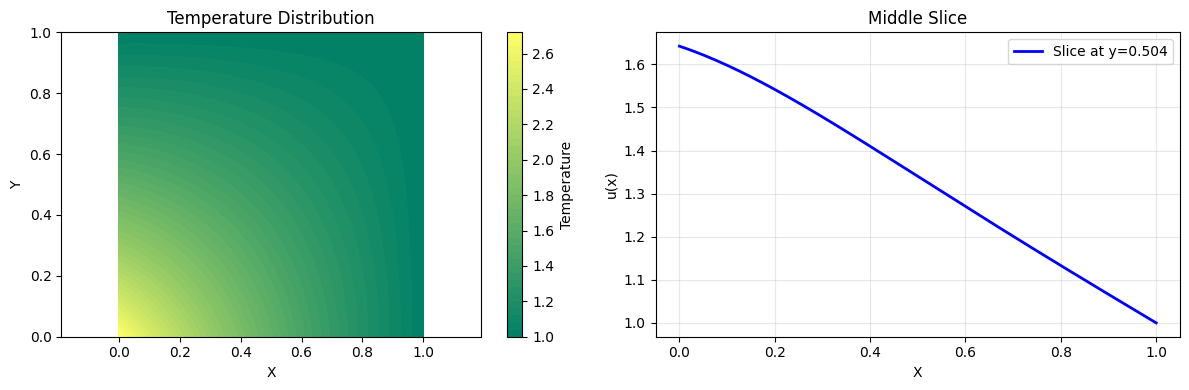

Min temperature: 1.0000
Max temperature: 2.7183
Center temperature: 1.3374


In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def quick_plot1():
    try:
        data = np.loadtxt('solution_laplace_cuda.txt', comments='#')
        x = data[:, 0]
        y = data[:, 1]
        u = data[:, 2]

        # Преобразование в сетку
        x_unique = np.unique(x)
        y_unique = np.unique(y)
        nx = len(x_unique)
        ny = len(y_unique)

        u_grid = u.reshape(nx, ny)
        X, Y = np.meshgrid(x_unique, y_unique, indexing='ij')

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        #plt.contourf(X, Y, u_grid, levels=50, cmap='cividis')
        plt.contourf(X, Y, u_grid, levels=50, cmap='summer')
        #plt.contourf(X, Y, u_grid, levels=50, cmap='Reds')
        plt.colorbar(label='Temperature')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Temperature Distribution')
        plt.axis('equal')

        plt.subplot(1, 2, 2)
        middle_y = ny // 2
        plt.plot(x_unique, u_grid[:, middle_y], 'b-', linewidth=2, label=f'Slice at y={y_unique[middle_y]:.3f}')
        plt.xlabel('X')
        plt.ylabel('u(x)')
        plt.title('Middle Slice')
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"Min temperature: {u_grid.min():.4f}")
        print(f"Max temperature: {u_grid.max():.4f}")
        print(f"Center temperature: {u_grid[nx//2, ny//2]:.4f}")

    except Exception as e:
        print(f"Error: {e}")

quick_plot1()

# other